# Create _Dataset_

Neste notebook são obtidos os _datasets_ de treinamento, teste e validação, a partir das _features_ coletadas no **ExtractFeatures.ipynb**.

São recolhidas todas as _features_ extraídas no _notebook_ anterior e realizado um _shuffling_ (embalhamento), fazendo com que os _batchs_ de treinamento sejam o mais aleatório possível.

Os principais parâmetros utilizados na extração estão situados no arquivo python __envparams.py__.

## Importação das bibliotecas  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import utils
from utils.envparams import *

import os

## Definição dos PATHs

In [2]:
PATH_root = '..'

PATH_speechDB = os.path.join(PATH_root, 'SpeechDatabase')
PATH_ptVoices = os.path.join(PATH_speechDB, 'portugueseVoices')
PATH_noise    = os.path.join(PATH_speechDB, 'soundNoise')


PATH_results         = 'results'
PATH_resultsSpeechDB = os.path.join(PATH_results, 'SpeechDatabase')
PATH_resultsDataaug  = os.path.join(PATH_results, 'DataAugmentation')
PATH_resultsExtFeat  = os.path.join(PATH_results, 'ExtractFeatures')
PATH_ExtFeatdicts    = os.path.join(PATH_resultsExtFeat, 'Dicionarios')
PATH_resultsCreateDS = os.path.join(PATH_results, 'CreateDataset')


## Load Speech Database Dictionaries

Carrega os dicionários obtidos no _notebook_ **ExtractFeatures.ipynb**.

In [3]:
trainPt  = np.load(os.path.join(PATH_ExtFeatdicts, 'trainPt.npy')).item()
testPt   = np.load(os.path.join(PATH_ExtFeatdicts, 'testPt.npy')).item()
validPt  = np.load(os.path.join(PATH_ExtFeatdicts, 'validPt.npy')).item()
trainNoise = np.load(os.path.join(PATH_ExtFeatdicts, 'trainNoise.npy')).item()
testNoise  = np.load(os.path.join(PATH_ExtFeatdicts, 'testNoise.npy')).item()
validNoise = np.load(os.path.join(PATH_ExtFeatdicts, 'validNoise.npy')).item()

## Organizando em _arrays_

Nesta etapa, são organizados as _features_ no tipo `nparray`. 

### Função utilizada

define a função utilizada nesta etapa

In [4]:
def createArrayFeat(dictSet, keyFeat='kwFeat'):

    fileFeat = np.array(dictSet[keyFeat])#.reshape(-1, 
                                          #          n_mfcc - ofs_mfcc, n_frames_MFCC)

    return fileFeat

### Organizando _trainPt_, _testPt_ e _validPt_ 

Organiza as _features_ extraídas para o **treinamento**, **teste** e **validação**, retiradas do _Database_ em portugues 

In [5]:
trainFeats = {}
for i in range(nkw):
    trainFeats['kw'+str(i)] = createArrayFeat(trainPt, keyFeat='kw'+str(i)+'Feat')

trainFeats['oov']   = createArrayFeat(trainPt, keyFeat='oovFeat')

In [6]:
testFeats = {}

for i in range(nkw):
    testFeats['kw'+str(i)] = createArrayFeat(testPt, keyFeat='kw'+str(i)+'Feat')
    
testFeats['oov']   = createArrayFeat(testPt, keyFeat='oovFeat')

In [7]:
validFeats = {}

for i in range(nkw):
    validFeats['kw'+str(i)] = createArrayFeat(validPt, keyFeat='kw'+str(i)+'Feat')
    
validFeats['oov']   = createArrayFeat(validPt, keyFeat='oovFeat')

### Organizando trainNoise e testNoise

Organiza as _features_ extraídas para o **treinamento e teste**, retiradas do _Database_ de ruídos. 

In [8]:
trainFeats['OOVnoise']  = createArrayFeat(trainNoise, keyFeat='oovFeat')
testFeats['OOVnoise']   = createArrayFeat(testNoise,  keyFeat='oovFeat')
validFeats['OOVnoise']  = createArrayFeat(validNoise, keyFeat='oovFeat')

## Concatena _Arrays_ e separa por classes

Nesta etapa é realizada a concatenação dos _arrays_ obtidos anteriormente e realizado o embaralhamento.

### Função utilizada 

Esta função obtém o _dataset_ e separa por classes, obtendo o vetor `y`. Também realiza um _Scrambling_ (embaralhamento) nas classes

In [9]:
def GetDataset(x):
    
    # aviso se entrada nao for tupla
    if type(x)!=tuple: 
        print('Entra deve ser Tupla')
        return
    
    # verifica número de classes que serao geradas 
    len_class = len(x)
    
    # define listas que serao utilizadas no "for"
    x_class = []
    y_class = []
    
    # varre as classes
    for i in range(len_class):
        
        # se possuir mais de um array na posicao da classe, concatena
        if type(x[i])==tuple: 
            x_class.append(np.concatenate(x[i]))
        else:
            x_class.append(x[i])
            
        # obtem o correspondente y para cada x
        y_class.append( (np.ones( (x_class[i].shape[0], 1) )*i).astype(int) )

    # gera x e y vazios
    xshape = list(x_class[0].shape)
    xshape[0] = 0
    x = np.zeros(tuple(xshape))
    yshape = list(y_class[0].shape)
    yshape[0] = 0
    y = np.zeros(tuple(yshape))
    
    # concatena os x e y
    for i in range(len_class):
        x = np.concatenate((x,x_class[i]))
        y = np.concatenate((y,y_class[i]))
    
    # toma o shape de x e y
    xshape = x.shape
    yshape = y.shape
    
    # concatena x e y e faz um scrambler (embaralhamento)
    x_n = x.reshape(xshape[0],-1)
    data = np.concatenate((x_n, y), axis=1)
    datascr = np.random.permutation(data)

    # gera mais uma dimensao em x para realizar o treinamento da rede (é necessario)
    xshape_new = list(xshape)
    xshape_new.append(1)
    
    # recupera x e y, agora embaralhados
    xscr = datascr[:,:datascr.shape[1]-yshape[1]].reshape(tuple(xshape_new))
    yscr = datascr[:,[datascr.shape[1]-yshape[1]]]

    return xscr, yscr

### _Dataset_ de treinamento

In [10]:
x_train, y_train = GetDataset( ( (trainFeats['oov']),
                                 (trainFeats['kw1']), 
                                 (trainFeats['kw2']) ) )
# x_train, y_train = GetDataset( ( (trainFeats['OOV'],   trainFeats['OOVAug'], trainFeats['OOVnoise']),
#                                  (trainFeats['abre'],  trainFeats['abreAug']), 
#                                  (trainFeats['fecha'], trainFeats['fechaAug']) ) )

#### pesquisa _feature_ desejada no _dataset_ e imprime

Está localizada na posição 4754 do dataset de treinamento
É da classe [1.]


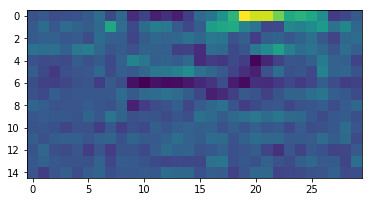

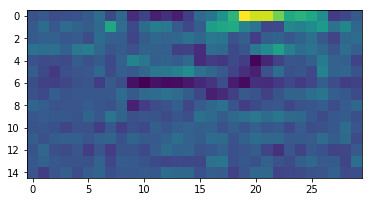

In [11]:
for i in range(x_train.shape[0]):
    feat = trainPt['kw1Feat'][4]
    if (x_train[i,:,:,0]==feat).all():
        print('Está localizada na posição',i,'do dataset de treinamento')
        print('É da classe', y_train[i])
        plt.imshow(trainPt['kw1Feat'][4])
        plt.show()        
        plt.imshow(x_train[i,:,:,0])
        plt.show()

### _Dataset_ de teste e validação

In [12]:
x_test, y_test = GetDataset( ( (testFeats['oov']),
                                testFeats['kw1'], 
                                testFeats['kw2'] ) )
# x_test_hat, y_test_hat = GetDataset( ( (testFeats['OOV'],   testFeats['OOVnoise']),
#                                         testFeats['abre'], 
#                                         testFeats['fecha'] ) )

In [13]:
x_valid, y_valid = GetDataset( ( (validFeats['oov']),
                                  validFeats['kw1'], 
                                  validFeats['kw2'] ) )

## Sumário 
Nesta etapa, imprime-se na tela um breve sumário dos _datasets_ de treinamento, teste e validação 

In [14]:
nclass=3
print('************ Brief Summary of DataSet **************\n')

print('-> Train dataset\n')

print('All Classes size:', x_train.shape[0])
print('OOV size:', x_train[y_train[:,0]==0].shape[0])
for i in range(nclass-1):
    print('Keyword '+str(i+1)+' size:', x_train[y_train[:,0]==i+1].shape[0])
# print('\nNoise OOV size:', trainFeats['OOVnoise'].shape[0])
print('Original speech OOV size:', trainFeats['oov'].shape[0])
# print('Augmented speech OOV size:', trainFeats['OOVAug'].shape[0])

print('\n')
print('-> Test dataset\n')

print('All Classes size:', x_test.shape[0])
print('OOV size:', x_test[y_test[:,0]==0].shape[0])
for i in range(nclass-1):
    print('Keyword '+str(i+1)+' size:', x_test[y_test[:,0]==i+1].shape[0])
# print('\nNoise OOV size:', testFeats['OOVnoise'].shape[0])
print('Original speech OOV size:', testFeats['oov'].shape[0])

print('-> Validation dataset\n')

print('All Classes size:', x_valid.shape[0])
print('OOV size:', x_valid[y_valid[:,0]==0].shape[0])
for i in range(nclass-1):
    print('Keyword '+str(i+1)+' size:', x_valid[y_valid[:,0]==i+1].shape[0])
# print('\nNoise OOV size:', testFeats['OOVnoise'].shape[0])
print('Original speech OOV size:', validFeats['oov'].shape[0])

************ Brief Summary of DataSet **************

-> Train dataset

All Classes size: 13505
OOV size: 3185
Keyword 1 size: 5160
Keyword 2 size: 5160
Original speech OOV size: 3185


-> Test dataset

All Classes size: 1600
OOV size: 400
Keyword 1 size: 600
Keyword 2 size: 600
Original speech OOV size: 400
-> Validation dataset

All Classes size: 1548
OOV size: 348
Keyword 1 size: 600
Keyword 2 size: 600
Original speech OOV size: 348


In [15]:
len(validPt['kw0Feat'])

600

## Salvar os _datasets_

Finalmente, os _datasets_ no diretório **CreateDateset**.

In [16]:
if not os.path.isdir(PATH_resultsCreateDS):
    os.makedirs(PATH_resultsCreateDS)

np.save(os.path.join(PATH_resultsCreateDS, 'x_train.npy'), x_train)
np.save(os.path.join(PATH_resultsCreateDS, 'y_train.npy'), y_train)
print('Train "ok"')
np.save(os.path.join(PATH_resultsCreateDS, 'x_test.npy'),  x_test)
np.save(os.path.join(PATH_resultsCreateDS, 'y_test.npy'),  y_test)
print('Test "ok"')
np.save(os.path.join(PATH_resultsCreateDS, 'x_valid.npy'), x_valid)
np.save(os.path.join(PATH_resultsCreateDS, 'y_valid.npy'), y_valid)
print('Validation "ok"')

Train "ok"
Test "ok"
Validation "ok"
